Thanks for kaggle and a lot of people joining this compition sharing their solution notebook!
Without those notebooks, it's impossible for me to build my owm Saint+ like model.
This model combines some ideas from different kernel and I try to make it as simple as possible.
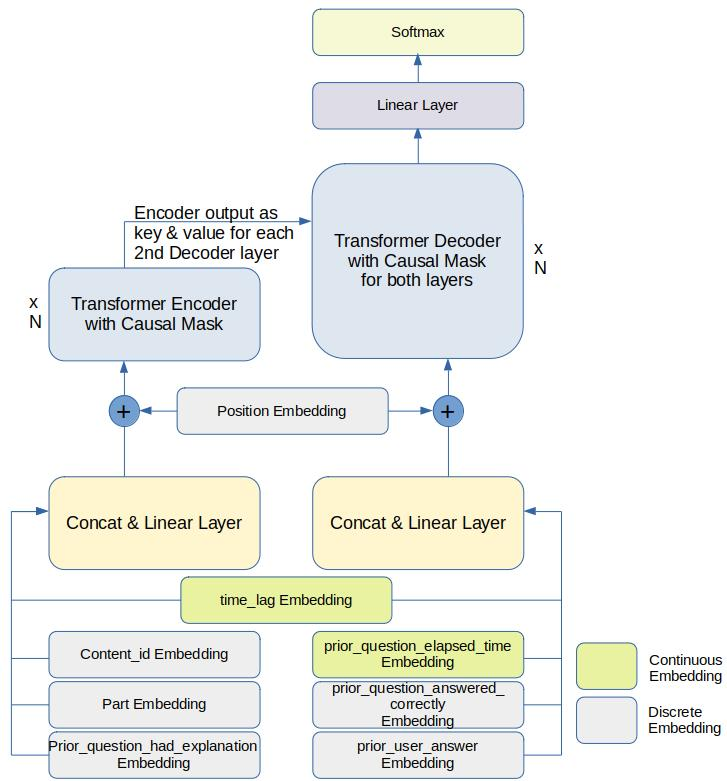

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import time
import pickle
import gc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# SAINT Dataset

In [ ]:
class Riiid_Sequence(Dataset):
    def __init__(self, groups, seq_len):
        self.samples = {}
        self.seq_len = seq_len
        self.user_ids = []

        for user_id in groups.index:
            c_id, part, t_c_id, t_lag, q_et, ans_c, q_he, u_ans = groups[user_id]
            if len(c_id) < 2:
                continue

            if len(c_id) > self.seq_len:
                initial = len(c_id) % self.seq_len
                if initial > 2:
                    self.user_ids.append(f"{user_id}_0")
                    self.samples[f"{user_id}_0"] = (
                        c_id[:initial], part[:initial], t_c_id[:initial], t_lag[:initial], 
                        q_et[:initial], ans_c[:initial], q_he[:initial], u_ans[:initial]
                    )
                chunks = len(c_id)//self.seq_len
                for c in range(chunks):
                    start = initial + c*self.seq_len
                    end = initial + (c+1)*self.seq_len
                    self.user_ids.append(f"{user_id}_{c+1}")
                    self.samples[f"{user_id}_{c+1}"] = (
                        c_id[start:end], part[start:end], t_c_id[start:end], t_lag[start:end], 
                        q_et[start:end], ans_c[start:end], q_he[start:end], u_ans[start:end]
                    )
            else:
                self.user_ids.append(f"{user_id}")
                self.samples[f"{user_id}"] = (c_id, part, t_c_id, t_lag, q_et, ans_c, q_he, u_ans)

    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, index):
        user_id = self.user_ids[index]
        c_id, p, t_c_id, t_lag, q_et, ans_c, q_he, u_ans = self.samples[user_id]
        seq_len = len(c_id)
        
        content_ids = np.zeros(self.seq_len, dtype=int)
        parts = np.zeros(self.seq_len, dtype=int)
        task_container_ids = np.zeros(self.seq_len, dtype=int)
        time_lag = np.zeros(self.seq_len, dtype=float)
        ques_elapsed_time = np.zeros(self.seq_len, dtype=float)
        answer_correct = np.zeros(self.seq_len, dtype=int)
        ques_had_explian = np.zeros(self.seq_len, dtype=int)
        user_answer = np.zeros(self.seq_len, dtype=int)
        label = np.zeros(self.seq_len, dtype=int)
  
        if seq_len == self.seq_len:
            content_ids[:] = c_id
            parts[:] = p
            task_container_ids[:] = t_c_id
            time_lag[:] = t_lag
            ques_elapsed_time[:] = q_et
            answer_correct[:] = ans_c
            ques_had_explian[:] = q_he
            user_answer[:] = u_ans
        else:
            content_ids[-seq_len:] = c_id
            parts[-seq_len:] = p
            task_container_ids[-seq_len:] = t_c_id
            time_lag[-seq_len:] = t_lag
            ques_elapsed_time[-seq_len:] = q_et
            answer_correct[-seq_len:] = ans_c
            ques_had_explian[-seq_len:] = q_he
            user_answer[-seq_len:] = u_ans
           
        content_ids = content_ids[1:]
        parts = parts[1:]
        task_container_ids = task_container_ids[1:]
        time_lag = time_lag[1:]
        ques_elapsed_time = ques_elapsed_time[1:]
        label = answer_correct[1:] - 1
        label = np.clip(label, 0, 1)
        
        answer_correct = answer_correct[:-1]
        ques_had_explian = ques_had_explian[1:]
        user_answer = user_answer[:-1]
        return content_ids, parts, time_lag, ques_elapsed_time, answer_correct, ques_had_explian, user_answer, label

# Transformer model(SAINT+ like)

In [ ]:
class FFN(nn.Module):
    def __init__(self, d_ffn, d_model, dropout=0.1):
        super(FFN, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ffn) #[batch, seq_len, ffn_dim]
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(d_ffn, d_model) #[batch, seq_len, d_model]
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.linear_2(x)
        return self.dropout(x)

class SaintPlus(nn.Module):
    def __init__(self, seq_len, num_layers, d_ffn, d_model, num_heads, max_len, n_questions, n_parts, n_tasks, n_ans, dropout=0.1):
        super(SaintPlus, self).__init__()
        self.d_model = d_model
        self.n_questions = n_questions
        self.num_heads = num_heads

        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.contentId_emb = nn.Embedding(n_questions+1, d_model)
        self.part_emb = nn.Embedding(n_parts+1, d_model)
        self.task_emb = nn.Embedding(n_tasks+1, d_model)

        self.timelag_emb = nn.Linear(1, d_model, bias=False)
        self.elapsedT_emb = nn.Linear(1, d_model, bias=False)

        self.answerCorr_emb = nn.Embedding(3, d_model)
        self.explan_emb = nn.Embedding(3, d_model)
        self.answer_emb = nn.Embedding(n_questions*4+1, d_model)

        self.emb_dense1 = nn.Linear(4*d_model, d_model)
        self.emb_dense2 = nn.Linear(4*d_model, d_model)

        self.transformer = nn.Transformer(d_model=d_model, nhead=num_heads, num_encoder_layers=num_layers, 
                                          num_decoder_layers=num_layers, dim_feedforward=d_ffn, dropout=dropout)
        self.layer_norm = nn.LayerNorm(d_model)
        self.FFN = FFN(d_ffn, d_model, dropout=dropout)
        self.final_layer = nn.Linear(d_model, 1)
    
    def forward(self, content_ids, parts, time_lag, ques_elapsed_time, answer_correct, ques_had_explian, user_answer):
        device = content_ids.device
        seq_len = content_ids.shape[1]

        content_id_emb = self.contentId_emb(content_ids)
        part_emb = self.part_emb(parts)
        # task = self.task_emb(x["task_container_id"])

        time_lag = torch.log(time_lag+1)
        time_lag = time_lag.view(-1, 1) # [batch*seq_len, 1]
        time_lag = self.timelag_emb(time_lag) # [batch*seq_len, d_model]
        time_lag = time_lag.view(-1, seq_len, self.d_model) # [batch, seq_len, d_model]
        elapsed_time = torch.log(ques_elapsed_time+1)
        elapsed_time = elapsed_time.view(-1, 1) # [batch*seq_len, 1]
        elapsed_time = self.elapsedT_emb(elapsed_time) # [batch*seq_len, d_model]
        elapsed_time = elapsed_time.view(-1, seq_len, self.d_model) # [batch, seq_len, d_model]    

        answer_correct_emb = self.answerCorr_emb(answer_correct)
        explain_emb = self.explan_emb(ques_had_explian)
        user_ans_id = torch.clamp((content_ids-1)*4+user_answer, 0, self.n_questions*4)
        answer_emb = self.answer_emb(user_ans_id)

        encoder_val = torch.cat((content_id_emb, part_emb, explain_emb, time_lag), axis=-1)
        encoder_val = self.emb_dense1(encoder_val)
        decoder_val = torch.cat((time_lag, elapsed_time, answer_correct_emb, answer_emb), axis=-1)
        decoder_val = self.emb_dense2(decoder_val)
        
        pos = torch.arange(seq_len).unsqueeze(0).to(device)
        pos_emb = self.pos_emb(pos)
        encoder_val += pos_emb
        decoder_val += pos_emb

        over_head_mask = torch.from_numpy(np.triu(np.ones((seq_len, seq_len)), k=1).astype('bool'))
        over_head_mask = over_head_mask.to(device)

        encoder_val = encoder_val.permute(1, 0, 2)
        decoder_val = decoder_val.permute(1, 0, 2)
        decoder_val = self.transformer(encoder_val, decoder_val, src_mask=over_head_mask, tgt_mask=over_head_mask, memory_mask=over_head_mask)

        decoder_val = self.layer_norm(decoder_val)
        decoder_val = decoder_val.permute(1, 0, 2)
        
        final_out = self.FFN(decoder_val)
        final_out = self.layer_norm(final_out + decoder_val)
        final_out = self.final_layer(final_out)
        final_out = torch.sigmoid(final_out)
        return final_out.squeeze(-1)

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

# Model training

In [ ]:
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_layers = 2
num_heads = 4
d_model = 128
d_ffn = d_model*4
max_len = 1000
n_questions = 13523
n_parts = 7
n_tasks = 10000
n_ans = 4

seq_len = 100
warmup_steps = 4000
dropout = 0.1
epochs = 30
batch_size = 512

with open("../input/riiid-training/train_group.pkl.zip", 'rb') as pick:
    train_group = pickle.load(pick)
with open("../input/riiid-training/val_group.pkl.zip", 'rb') as pick:
    val_group = pickle.load(pick)

train_seq = Riiid_Sequence(train_group, seq_len)
train_size = len(train_seq)
train_loader = DataLoader(train_seq, batch_size=batch_size, shuffle=True, num_workers=8)
del train_seq, train_group

val_seq = Riiid_Sequence(val_group, seq_len)
val_size = len(val_seq)
val_loader = DataLoader(val_seq, batch_size=batch_size, shuffle=False, num_workers=8)
del val_seq, val_group

loss_fn = nn.BCELoss()
model = SaintPlus(seq_len=100, num_layers=num_layers, d_ffn=d_ffn, d_model=d_model, num_heads=num_heads,
                  max_len=max_len, n_questions=n_questions, n_parts=n_parts, n_tasks=n_tasks, 
                  n_ans=n_ans, dropout=dropout)
optimizer = NoamOpt(d_model, 1, 4000 ,optim.Adam(model.parameters(), lr=0))
model.to(device)
loss_fn.to(device)

train_losses = []
val_losses = []
val_aucs = []
best_auc = 0
for e in range(epochs):
    print("==========Epoch {} Start Training==========".format(e+1))
    model.train()
    t_s = time.time()
    train_loss = []
    pbar = tqdm(total=train_size)
    for step, data in enumerate(train_loader):
        content_ids = data[0].to(device).long()
        parts = data[1].to(device).long()
        time_lag = data[2].to(device).float()
        ques_elapsed_time = data[3].to(device).float()
        answer_correct = data[4].to(device).long()
        ques_had_explian = data[5].to(device).long()
        user_answer = data[6].to(device).long()
        label = data[7].to(device).float()

        optimizer.optimizer.zero_grad()

        preds = model(content_ids, parts, time_lag, ques_elapsed_time, answer_correct, ques_had_explian, user_answer)
        loss_mask = (answer_correct != 0)
        preds_masked = torch.masked_select(preds, loss_mask)
        label_masked = torch.masked_select(label, loss_mask)
        loss = loss_fn(preds_masked, label_masked)

        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        pbar.update(len(content_ids))
            
    train_loss = np.mean(train_loss)
    print("==========Epoch {} Start Validation==========".format(e+1))
    model.eval()
    val_loss = []
    val_labels = []
    val_preds = []
    for step, data in enumerate(val_loader):
        content_ids = data[0].to(device).long()
        parts = data[1].to(device).long()
        time_lag = data[2].to(device).float()
        ques_elapsed_time = data[3].to(device).float()
        answer_correct = data[4].to(device).long()
        ques_had_explian = data[5].to(device).long()
        user_answer = data[6].to(device).long()
        label = data[7].to(device).float()

        preds = model(content_ids, parts, time_lag, ques_elapsed_time, answer_correct, ques_had_explian, user_answer)
        loss_mask = (answer_correct != 0)
        preds_masked = torch.masked_select(preds, loss_mask)
        label_masked = torch.masked_select(label, loss_mask)

        val_loss.append(loss.item())
        val_labels.extend(label_masked.view(-1).data.cpu().numpy())
        val_preds.extend(preds_masked.view(-1).data.cpu().numpy())

    val_loss = np.mean(val_loss)
    val_auc = roc_auc_score(val_labels, val_preds)
    
    if val_auc > best_auc:
        print("Save model at epoch {}".format(e+1))
        torch.save(model.state_dict(), "./saint.pt")
        best_auc = val_auc
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)
    exec_t = int((time.time() - t_s)/60)
    print("Train Loss {:.4f}/ Val Loss {:.4f}, Val AUC {:.4f} / Exec time {} min".format(train_loss, val_loss, val_auc, exec_t))